In [13]:
import numpy as np
import pandas as pd
import pickle
import smogn

import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [14]:
df = pd.read_csv("/Users/admin/Downloads/parklane_combined_edited.csv")
print('Unfiltered row of dataframe is {}'.format(len(df)))

Unfiltered row of dataframe is 727657


### This notebook focus will be on predicting ch_sysef using various features and some selections of models

total number of rows after filter is 211004


ValueError: Could not interpret value `wea_ct_wb` for `x`. An entry with this name does not appear in `data`.

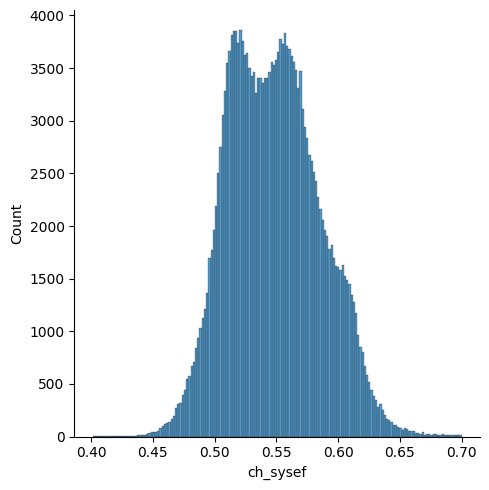

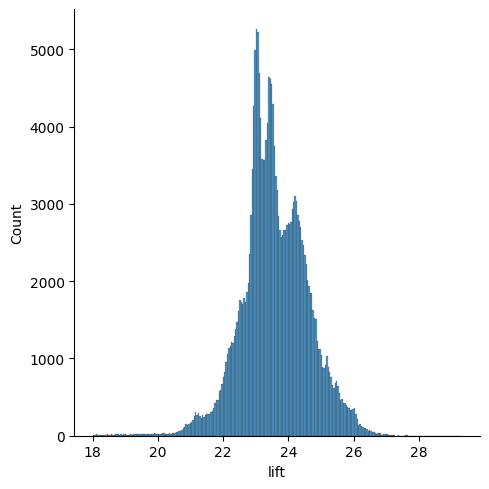

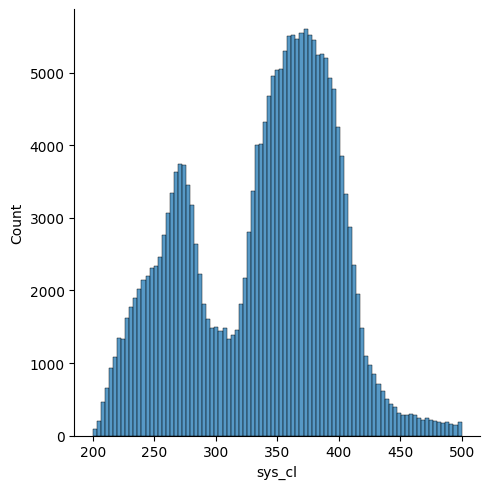

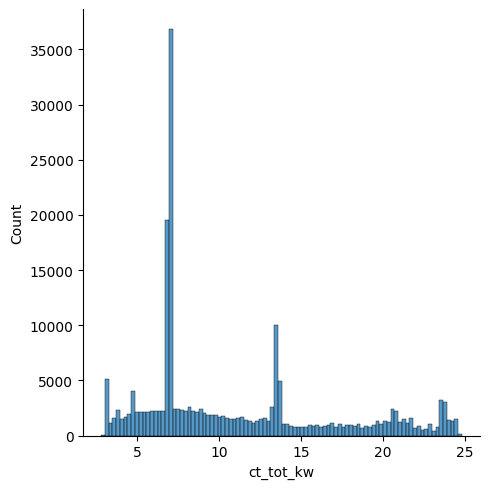

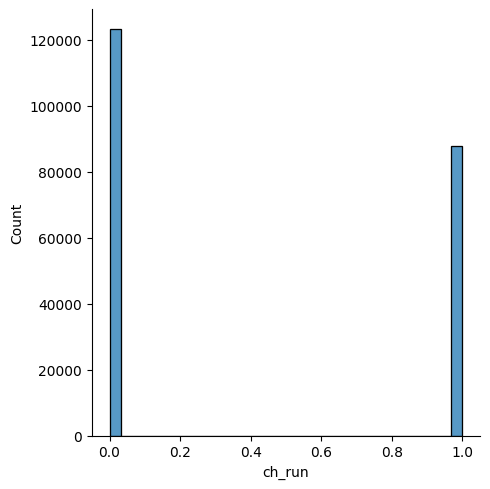

In [15]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
# both chillers running
fil_df['ch_run'] = (fil_df['ch_1_kwe']>=2) & (fil_df['ch_2_kwe']>=2)
fil_df['ch_run'] = fil_df['ch_run'].astype(int)

# filtering additional columns
fil_df = fil_df[(fil_df['ct_tot_kw']>=2) & (fil_df['ct_tot_kw']<=30)]
fil_df = fil_df[(fil_df['lift']>=18) & (fil_df['lift']<=30)]

print("total number of rows after filter is {}".format(len(fil_df)))

# selecting related features only
ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw', 'ch_run', 'h_cwst']]
# reset
ch_sysef_df = ch_sysef_df.reset_index()

# distribution
sns.displot(ch_sysef_df, x="ch_sysef")
sns.displot(ch_sysef_df, x="lift")
sns.displot(ch_sysef_df, x="sys_cl")
sns.displot(ch_sysef_df, x="ct_tot_kw")
sns.displot(ch_sysef_df, x="ch_run")
sns.displot(ch_sysef_df, x="wea_ct_wb")

In [17]:
saved_df = ch_sysef_df.drop("ch_run", axis=1)
saved_df = saved_df[:1000]
saved_df.to_csv("train.csv", index=False)
saved_df.head(5)

,index,ch_sysef,lift,sys_cl,ct_tot_kw,h_cwst
0,646,0.497447,19.139454,352.233795,7.056000,26.070417
1,648,0.550988,18.783153,349.504547,7.088001,26.830719
2,649,0.570091,19.933795,360.257111,7.104001,27.225933
3,650,0.570109,20.829254,370.950195,7.072001,27.347572
4,651,0.572669,21.348466,374.542725,7.056001,27.346157


## Training

In [47]:
# train_test split
X = ch_sysef_df[['lift', 'sys_cl', 'ct_tot_kw', 'ch_run', 'wea_ct_wb']]
y = ch_sysef_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

# Training
no_of_trees = [100, 500]
min_samples_splits = [100, 500, 1000, 5000]

parameter_grid = {
    'max_depth': no_of_trees,
    'min_samples_split': min_samples_splits
}

grid_search = GridSearchCV(
    estimator= RandomForestRegressor(),
    param_grid=parameter_grid,
    cv=5
)

regr = RandomForestRegressor()
grid_search.fit(X_train, y_train)

## save model
filename = 'RF_first_both_ch_wb.sav'
pickle.dump(grid_search, open(filename, 'wb'))

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_valida

In [58]:
from sklearn.inspection import permutation_importance

result = permutation_importance(grid_search, X_test, y_test, random_state=42)
perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = X_test.columns

pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=True)

,Importance,Std
ct_tot_kw,0.182661,0.002296
sys_cl,0.282685,0.002897
wea_ct_wb,0.422652,0.003589
ch_run,0.445396,0.001799
lift,0.712640,0.005986


In [60]:
global_importances = pd.Series(grid_search.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

### Random Forest Regressor

In [48]:
grid_search.best_params_

{'max_depth': 100, 'min_samples_split': 100}

In [49]:
X_test.iloc[100]

lift          25.000000
sys_cl       379.290222
ct_tot_kw     20.672002
ch_run         0.000000
wea_ct_wb     27.332203
Name: 106063, dtype: float64

In [50]:
y_test.iloc[100]

ch_sysef    0.620052
Name: 106063, dtype: float64

In [54]:
grid_search.predict([[25, 379.29, 20.67, 0, 27.33]])

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.6280282])

In [ ]:
import pickle
model = pickle.load(open('/Users/admin/Desktop/optimization/parklane/RF_first_both_ch.sav', 'rb'))

model.predict([[23.32, 338.77, 5.296, 1, 75, 75]])

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.51148131])

## SMOGN

In [ ]:
ch_sysef_df_smogn = smogn.smoter(
    data=ch_sysef_df,
    y='ch_sysef'
)

# distribution
sns.displot(ch_sysef_df_smogn, x="ch_sysef")
sns.displot(ch_sysef_df_smogn, x="lift")
sns.displot(ch_sysef_df_smogn, x="sys_cl")
sns.displot(ch_sysef_df_smogn, x="ct_tot_kw")
sns.displot(ch_sysef_df_smogn, x="both_ch")
sns.displot(ch_sysef_df_smogn, x="ch_1_kwe")
sns.displot(ch_sysef_df_smogn, x="ch_2_kwe")

dist_matrix:  18%|#7        | 1880/10578 [2:08:37<9:55:07,  4.11s/it]    


KeyboardInterrupt: 